# 상위 10개 순위 맵

In [2]:
# ----------------- 필수 라이브러리 -----------------
import pandas as pd
import folium
from folium.plugins import HeatMap
import numpy as np

# ----------------- 기상 데이터 -----------------
weather_data = {
    '위도': [37.741, 35.2865939, 36.59627, 34.88229739, 36.55629, 36.61283,
             36.86771, 35.28075866, 34.82641918, 37.6044],
    '경도': [128.7394, 126.3413102, 129.1988, 125.9978663, 129.2412, 129.2134,
             129.392, 126.3477155, 126.7597344, 128.2809],
    '평균기온(℃)': [7.1, 13.1, 11.2, 13.1, 11.2, 11.2, 12.8, 13.1, 13.7, 11.1],
    '최고기온(℃)': [12.2, 18.3, 17.7, 18.3, 17.7, 17.7, 17.5, 18.3, 19.3, 18.0],
    '최저기온(℃)': [2.3, 8.5, 5.5, 8.5, 5.5, 5.5, 8.7, 8.5, 8.9, 5.5],
    '강수량(mm)': [1695.1, 1277.8, 996.7, 1277.8, 996.7, 996.7, 1181.7, 1277.8, 1218.4, 1331.5]
}
df_weather = pd.DataFrame(weather_data)

# ----------------- 풍력발전소 데이터 -----------------
all_farms = pd.read_excel("datas/Windfarm_Data.xlsx")
all_farms["발전량(MW)"] = pd.to_numeric(all_farms["발전량(MW)"], errors="coerce")

# 좌표 처리
if "좌표" in all_farms.columns:
    all_farms[["위도_tmp", "경도_tmp"]] = all_farms["좌표"].astype(str).str.split("\t", expand=True)
    all_farms["위도"] = all_farms["위도"].combine_first(all_farms["위도_tmp"]).astype(float)
    all_farms["경도"] = all_farms["경도"].combine_first(all_farms["경도_tmp"]).astype(float)

# NaN 제거
all_farms = all_farms.dropna(subset=["위도", "경도"])

# ----------------- 상위 10개 단지명 JSON key와 일치 -----------------
all_farms_sorted = all_farms.sort_values('발전량(MW)', ascending=False, na_position='last')
top_10_indices = all_farms_sorted.head(10).index

rename = [
    "강원풍력발전",
    "한국동서발전_영광",
    "영양에코파워",
    "신안1,2_포스코에너지",
    "삼탄_영양",
    "GS_E&R_영양",
    "SK_D&D_울진",
    "한국동서발전_영광백수",
    "영암_대명GEC",
    "태기산_강원도"
]

# JSON key와 정확히 일치하도록 단지명 변경
for i, idx in enumerate(top_10_indices):
    all_farms.at[idx, '단지명'] = rename[i]


# ----------------- 지도 생성 -----------------
m = folium.Map(location=[36, 127], tiles="CartoDB Positron", zoom_start=7)
icon_size = (10, 10)

# ----------------- 마커 추가 -----------------
for idx, farm in all_farms.iterrows():
    farm_name = str(farm.get('단지명', '풍력발전소')).replace("'", "")
    region = str(farm.get('지역', 'N/A')).replace("'", "")
    capacity = str(farm.get('발전량(MW)', 'N/A')).replace("'", "")
    
    popup_text = f"""
    <div style='width: 200px; font-family: Arial, sans-serif;'>
        <h4 style='margin: 5px 0; color: #2E4057;'>{farm_name}</h4>
        <hr style='margin: 5px 0;'>
        <p style='margin: 3px 0;'><b>지역:</b> {region}</p>
        <p style='margin: 3px 0;'><b>발전량:</b> {capacity} MW</p>
        <button onclick="parent.postMessage({{type:'markerClick',name:'{farm_name}',region:'{region}',capacity:'{capacity}'}}, '*');" 
                style='background: #2E4057; color: white; border: none; padding: 5px 10px; border-radius: 3px; cursor: pointer; margin-top: 10px;'>
            상세보기
        </button>
    </div>
    """
    
    if idx in top_10_indices:
        capacity_val = farm.get('발전량(MW)', 0)
        if pd.isna(capacity_val): 
            marker_color = 'black' 
        elif capacity_val >= 90: 
            marker_color = 'darkblue' 
        elif capacity_val >= 60: 
            marker_color = 'blue'  
        else: 
            marker_color = 'lightblue' 

        folium.Marker(
            location=[farm["위도"], farm["경도"]],
            popup=folium.Popup(popup_text, max_width=300),
            icon=folium.Icon(
                color=marker_color,
                icon='wind',
                prefix='fa'
            )
        ).add_to(m)
    else:
        try:
            icon = folium.CustomIcon(
                icon_image="datas/dot.png",
                icon_size=icon_size
            )
            folium.Marker(
                location=[farm["위도"], farm["경도"]],
                icon=icon,
            ).add_to(m)
        except:
            folium.CircleMarker(
                location=[farm["위도"], farm["경도"]],
                radius=4,
                fillColor='lightblue',
                color='navy',
                weight=1,
                fillOpacity=0.7
            ).add_to(m)

            
# ---------------- 히트맵 부분 (기존과 동일) ----------------
# 1. 평균기온 히트맵
avg_temp_fg = folium.FeatureGroup(name="평균기온 히트맵", show=True)
avg_temp_data = [[row['위도'], row['경도'], row['평균기온(℃)']] for idx, row in df_weather.iterrows()]
HeatMap(
    avg_temp_data,
    radius=30,
    gradient={0.0: 'blue', 0.3: 'cyan', 0.5: 'lime', 0.7: 'yellow', 1.0: 'red'},
    min_opacity=0.3,
    max_zoom=18,
    blur=25
).add_to(avg_temp_fg)

# 2. 최고기온 히트맵
max_temp_fg = folium.FeatureGroup(name="최고기온 히트맵", show=False)
max_temp_data = [[row['위도'], row['경도'], row['최고기온(℃)']] for idx, row in df_weather.iterrows()]
HeatMap(
    max_temp_data,
    radius=30,
    gradient={0.0: 'orange', 0.5: 'red', 1.0: 'darkred'},
    min_opacity=0.3,
    max_zoom=18,
    blur=25
).add_to(max_temp_fg)

# 3. 최저기온 히트맵
min_temp_fg = folium.FeatureGroup(name="최저기온 히트맵", show=False)
min_temp_data = [[row['위도'], row['경도'], row['최저기온(℃)']] for idx, row in df_weather.iterrows()]
HeatMap(
    min_temp_data,
    radius=30,
    gradient={0.0: 'darkblue', 0.5: 'blue', 1.0: 'lightblue'},
    min_opacity=0.3,
    max_zoom=18,
    blur=25
).add_to(min_temp_fg)

# 4. 강수량 히트맵
rainfall_fg = folium.FeatureGroup(name="강수량 히트맵", show=False)
min_rain = df_weather['강수량(mm)'].min()
max_rain = df_weather['강수량(mm)'].max()
rainfall_data = [[row['위도'], row['경도'], (row['강수량(mm)'] - min_rain) / (max_rain - min_rain)]
                 for idx, row in df_weather.iterrows()]
HeatMap(
    rainfall_data,
    radius=30,
    gradient={0.0: 'lightgreen', 0.3: 'green', 0.6: 'blue', 1.0: 'darkblue'},
    min_opacity=0.3,
    max_zoom=18,
    blur=25
).add_to(rainfall_fg)

# 모든 레이어를 지도에 추가
avg_temp_fg.add_to(m)
max_temp_fg.add_to(m)
min_temp_fg.add_to(m)
rainfall_fg.add_to(m)

# 모든 레이어 추가
avg_temp_fg.add_to(m)
max_temp_fg.add_to(m)
min_temp_fg.add_to(m)
rainfall_fg.add_to(m)
folium.LayerControl().add_to(m)

# 지도 출력
m.save("map01.html")



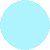
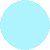
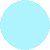
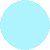
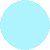
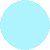
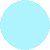
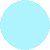
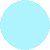
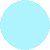
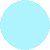
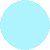
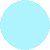
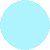
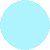
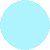
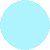
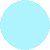
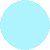
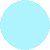
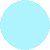
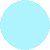
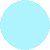
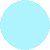
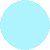
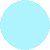
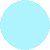
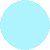
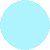
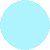
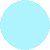
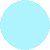
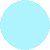
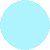
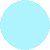
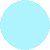
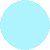
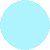
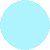
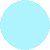
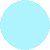
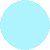
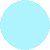
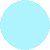
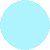
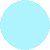
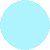
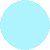
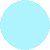
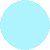
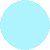
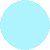
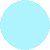
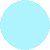
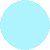
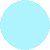
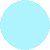
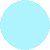
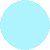
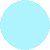
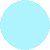
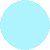
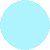
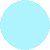
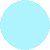
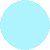
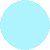
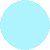
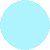
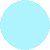
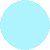
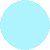
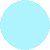
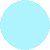
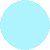
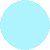
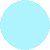
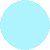
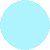
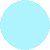
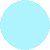

In [3]:
m

# 하위 10개 순위 맵


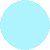
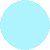
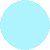
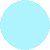
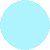
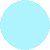
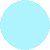
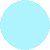
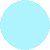
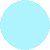
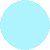
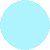
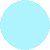
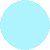
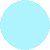
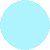
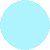
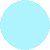
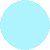
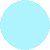
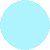
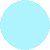
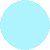
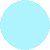
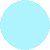
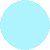
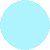
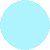
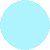
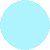
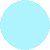
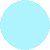
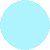
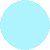
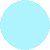
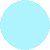
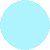
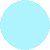
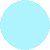
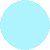
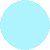
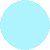
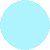
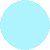
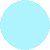
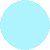
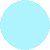
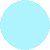
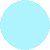
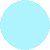
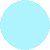
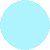
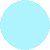
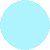
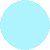
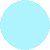
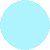
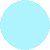
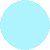
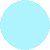
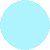
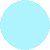
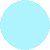
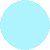
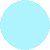
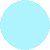
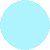
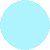
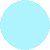
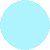
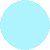
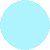
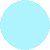
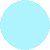
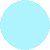
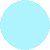
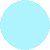
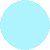
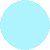
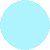
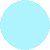

In [13]:
# ----------------- 필수 라이브러리 -----------------
import pandas as pd
import folium
from folium.plugins import HeatMap
import numpy as np

# ----------------- 기상 데이터 -----------------
weather_data = {
    '발전량(MW)': [0.4, 0.5, 0.75, 0.75, 0.75, 0.75, 1.5, 1.65, 1.65, 1.7],
    '위도': [34.47342188, 33.16771669, 34.76806819, 33.56055401, 35.33516, 34.90265,
             33.56298551, 35.71247661, 35.52651, 33.34244878],
    '경도': [126.0523492, 126.2690342, 126.4166, 126.7732691, 129.2945, 128.112,
             126.7821355, 126.5981115, 129.4537, 126.1780464],
    '평균기온(℃)': [13.9, 16.9, 13.7, 15.6, 15.4, 14.7, 15.6, 12.9, 14.4, 16.2],
    '최고기온(℃)': [18.6, 20.3, 19.3, 19.2, 19.1, 18.9, 19.2, 18.3, 19.4, 19.3],
    '최저기온(℃)': [9.6, 13.9, 8.9, 12.1, 12, 11.3, 12.1, 8.4, 10.2, 13.4],
    '강수량(mm)': [1374.7, 1989.6, 1218.4, 2030, 1514, 1446.3, 2030, 1238, 1292.6, 1502.3]
}


# DataFrame 생성
df_weather = pd.DataFrame(weather_data)

# ----------------- 풍력발전소 데이터 -----------------
all_farms = pd.read_excel("datas/Windfarm_Data.xlsx")
all_farms["발전량(MW)"] = pd.to_numeric(all_farms["발전량(MW)"], errors="coerce")

# 좌표 처리
if "좌표" in all_farms.columns:
    all_farms[["위도_tmp", "경도_tmp"]] = all_farms["좌표"].astype(str).str.split("\t", expand=True)
    all_farms["위도"] = all_farms["위도"].combine_first(all_farms["위도_tmp"]).astype(float)
    all_farms["경도"] = all_farms["경도"].combine_first(all_farms["경도_tmp"]).astype(float)

all_farms = all_farms.dropna(subset=["위도", "경도"])

# ----------------- 하위 10개 단지명 JSON key와 일치 -----------------
all_farms_sorted = all_farms.sort_values('발전량(MW)', ascending=True, na_position='last')
bottom_10_indices = all_farms_sorted.head(10).index

# JSON 키 순서대로 단지명 리스트
rename_names = [
    "가사도_한국전력",
    "가파도_한국남부발전",
    "대불_영암군청",
    "김녕_제주도청",
    "고리_한국수력원자력",
    "삼천포_한국남동발전",
    "월정_한국에너지기술연구원",
    "부안_디앤아이코퍼레이션",
    "현대중공업_울산",
    "신창_제주에너지공사"
]

# 하위 10개 단지명을 rename_names 리스트대로 실제 변경
for i, idx in enumerate(bottom_10_indices):
    all_farms.at[idx, '단지명'] = rename_names[i]

# ----------------- 지도 생성 -----------------
m = folium.Map(location=[36, 127], tiles="CartoDB dark_matter", zoom_start=7)
icon_size = (10, 10)

# ----------------- 마커 추가 -----------------
for idx, farm in all_farms.iterrows():
    farm_name = str(farm.get('단지명', '풍력발전소')).replace("'", "")
    region = str(farm.get('지역', 'N/A')).replace("'", "")
    capacity = str(farm.get('발전량(MW)', 'N/A')).replace("'", "")
    
    popup_text = f"""
    <div style='width: 200px; font-family: Arial, sans-serif;'>
        <h4 style='margin: 5px 0; color: #2E4057;'>{farm_name}</h4>
        <hr style='margin: 5px 0;'>
        <p style='margin: 3px 0;'><b>지역:</b> {region}</p>
        <p style='margin: 3px 0;'><b>발전량:</b> {capacity} MW</p>
        <button onclick="parent.postMessage({{type:'markerClick',name:'{farm_name}',region:'{region}',capacity:'{capacity}'}}, '*');" 
                style='background: #2E4057; color: white; border: none; padding: 5px 10px; border-radius: 3px; cursor: pointer; margin-top: 10px;'>
            상세보기
        </button>
    </div>
    """
    
    if idx in bottom_10_indices: 
        capacity = farm.get('발전량(MW)', 0) 
        if pd.isna(capacity): 
            marker_color = 'black' 
        elif capacity >= 90: 
            marker_color = 'darkblue' 
        elif capacity >= 60: 
            marker_color = 'darkred'  
        else: 
            marker_color = 'red' 

        folium.Marker(
            location=[farm["위도"], farm["경도"]],
            popup=folium.Popup(popup_text, max_width=300),
            icon=folium.Icon(
                color=marker_color,
                icon='wind',
                prefix='fa'
            )
        ).add_to(m)
    else:
        try:
            icon = folium.CustomIcon(
                icon_image="datas/dot.png",
                icon_size=icon_size
            )
            folium.Marker(
                location=[farm["위도"], farm["경도"]],
                icon=icon,
            ).add_to(m)
        except:
            folium.CircleMarker(
                location=[farm["위도"], farm["경도"]],
                radius=4,
                fillColor='lightblue',
                color='navy',
                weight=1,
                fillOpacity=0.7
            ).add_to(m)

# ----------------- 히트맵 -----------------
# 평균기온
avg_temp_fg = folium.FeatureGroup(name="평균기온 히트맵", show=True)
avg_temp_data = [[row['위도'], row['경도'], row['평균기온(℃)']] for idx, row in df_weather.iterrows()]
HeatMap(
    avg_temp_data,
    radius=30,
    gradient={0.0: 'blue', 0.3: 'cyan', 0.5: 'lime', 0.7: 'yellow', 1.0: 'red'},
    min_opacity=0.3,
    max_zoom=18,
    blur=25
).add_to(avg_temp_fg)

# 최고기온
max_temp_fg = folium.FeatureGroup(name="최고기온 히트맵", show=False)
max_temp_data = [[row['위도'], row['경도'], row['최고기온(℃)']] for idx, row in df_weather.iterrows()]
HeatMap(
    max_temp_data,
    radius=30,
    gradient={0.0: 'orange', 0.5: 'red', 1.0: 'darkred'},
    min_opacity=0.3,
    max_zoom=18,
    blur=25
).add_to(max_temp_fg)

# 최저기온
min_temp_fg = folium.FeatureGroup(name="최저기온 히트맵", show=False)
min_temp_data = [[row['위도'], row['경도'], row['최저기온(℃)']] for idx, row in df_weather.iterrows()]
HeatMap(
    min_temp_data,
    radius=30,
    gradient={0.0: 'darkblue', 0.5: 'blue', 1.0: 'lightblue'},
    min_opacity=0.3,
    max_zoom=18,
    blur=25
).add_to(min_temp_fg)

# 강수량
rainfall_fg = folium.FeatureGroup(name="강수량 히트맵", show=False)
min_rain = df_weather['강수량(mm)'].min()
max_rain = df_weather['강수량(mm)'].max()
rainfall_data = [[row['위도'], row['경도'], (row['강수량(mm)'] - min_rain) / (max_rain - min_rain)]
                 for idx, row in df_weather.iterrows()]
HeatMap(
    rainfall_data,
    radius=30,
    gradient={0.0: 'lightgreen', 0.3: 'green', 0.6: 'blue', 1.0: 'darkblue'},
    min_opacity=0.3,
    max_zoom=18,
    blur=25
).add_to(rainfall_fg)

# 모든 레이어 추가
avg_temp_fg.add_to(m)
max_temp_fg.add_to(m)
min_temp_fg.add_to(m)
rainfall_fg.add_to(m)
folium.LayerControl().add_to(m)

# 지도 저장
m
